In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers



Total number of ETFs: 33


In [2]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [3]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)
# label_df =pd.DataFrame(label)
# label_df.set_index('Date', inplace=True)
# display(type(label_df))

In [4]:

def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels



In [5]:
window_size = 30
dataset_size = len(data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:train_size + val_size]
test_data = data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]


X_train, y_train, first_values_train, labels_train = create_X_y_rolling(train_data, binary_targets_train, window_size)
X_val, y_val, first_values_val, labels_val = create_X_y_rolling(val_data, binary_targets_val, window_size)
X_test, y_test, first_values_test, labels_test = create_X_y_rolling(test_data, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (312, 30, 33),
 (312, 33),
 (310, 30, 33),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [6]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False, activation='linear'),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.4293 - mean_squared_error: 0.4292 - val_loss: 0.0138 - val_mean_squared_error: 0.0137
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 0.0057 - val_mean_squared_error: 0.0056
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0042 - val_mean_squared_error: 0.0041
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.

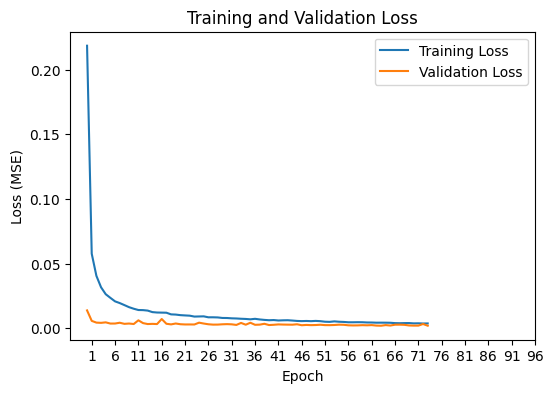

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model = load_model('model_regression/best_LSTM.keras')
index_series = data.index[-len(y_test):]  # Use the last indices for the test set

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

display(Predict_result_df)

# Predict_result_df["SPY"].plot()


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,33.559439,8.822221,76.285262,21.737618,13.727709,109.492027,51.588096,21.883388,34.453656,28.871837,...,22.186314,463.345908,89.234396,66.839206,113.393236,112.330512,60.733090,82.711481,67.398681,6.861546
2024-01-18,32.810875,8.769202,78.097182,21.671688,13.650076,108.323404,51.355366,21.632293,34.323909,28.944529,...,21.855922,461.577352,90.280547,66.659126,112.110516,112.296306,60.663722,81.689018,66.955380,6.784801
2024-01-19,32.654065,8.722761,77.718265,21.492190,13.535937,107.228188,51.135666,21.720252,34.110293,28.833662,...,21.679274,457.048874,90.319600,66.345766,111.038356,111.901409,60.423151,80.842048,66.914255,6.739659
2024-01-22,32.846323,8.693086,77.147811,21.563954,13.567920,106.784546,51.154241,21.830036,33.897311,28.829704,...,21.492722,458.494746,89.593772,66.647379,109.921201,111.268137,60.352722,80.726361,67.150000,6.609750
2024-01-23,33.066000,8.686071,78.837523,21.564981,13.618821,106.635041,50.870377,21.853836,33.853053,28.905912,...,20.914161,458.280480,89.066289,67.329038,109.653757,111.229559,60.391472,80.362422,66.903999,6.524096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.051622,10.800345,110.845471,20.155519,14.600676,111.543244,57.534557,25.419496,42.208906,37.089065,...,29.135085,611.476773,87.121074,77.608426,123.066521,146.825934,69.980868,91.164448,76.305779,7.763169
2025-03-25,40.694792,10.839111,110.224683,20.011961,14.715955,112.723074,57.446088,25.385479,42.220765,37.498933,...,29.081366,611.444464,86.698122,78.027469,124.013580,146.841520,70.373310,91.478295,76.180650,7.751062
2025-03-26,40.730839,10.814507,109.572786,20.183993,14.613107,111.921869,57.235318,25.575200,42.075246,37.622392,...,29.283059,610.113569,85.329539,77.826210,122.648848,145.889083,70.715743,90.740526,75.687610,7.730969


In [9]:
Y_pred

array([[1.036348  , 0.971568  , 1.0212218 , ..., 1.0426239 , 1.0303286 ,
        1.0304556 ],
       [1.0346729 , 0.9814704 , 1.0157661 , ..., 1.0366172 , 1.030112  ,
        1.030929  ],
       [1.0290837 , 0.9800001 , 1.009656  , ..., 1.0289395 , 1.0221834 ,
        1.0279747 ],
       ...,
       [0.9906564 , 1.0496306 , 0.9694991 , ..., 1.0058444 , 1.0377847 ,
        1.0373659 ],
       [0.983233  , 1.0481975 , 0.96245325, ..., 0.9972086 , 1.0296308 ,
        1.0307705 ],
       [0.98123586, 1.0355396 , 0.96336865, ..., 0.99780035, 1.0273916 ,
        1.0321021 ]], dtype=float32)

In [10]:
# SUMMARY
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = np.sqrt(mse)


print("Mean Absolute Error for not normalized:", mae)
print("Mean Squared Error for not normalized:", mse)
print("Root Mean Squared Error for not normalized:", rmse)

r2 = r2_score(y_test, Y_pred)
r2_denorm = r2_score(y_test_denorm, Y_pred_denorm)
print("R² Score (normalized):", r2)
print("R² Score (denormalized):", r2_denorm)



Mean Absolute Error for not normalized: 0.03209941087103177
Mean Squared Error for not normalized: 0.0019011628808284274
Root Mean Squared Error for not normalized: 0.04360232655293095
R² Score (normalized): 0.3390646139279225
R² Score (denormalized): 0.4081564606868081


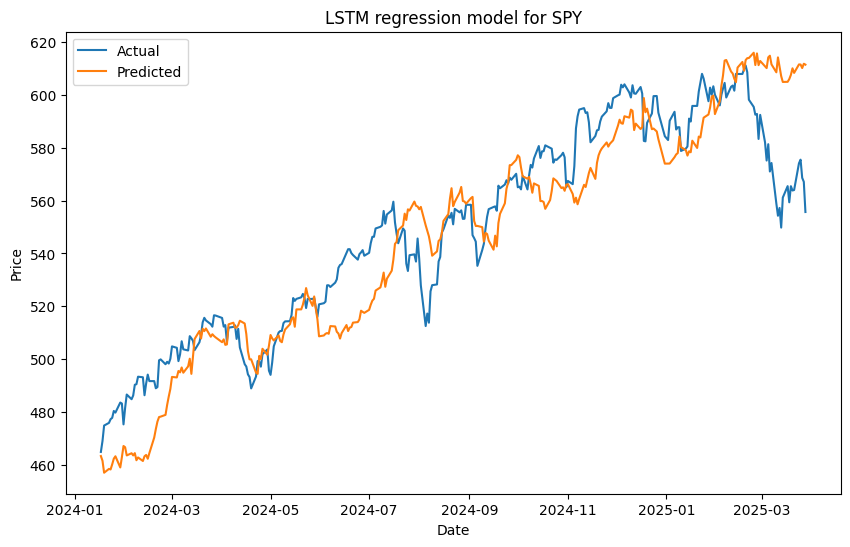

In [11]:
ticker_name = 'SPY'
plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

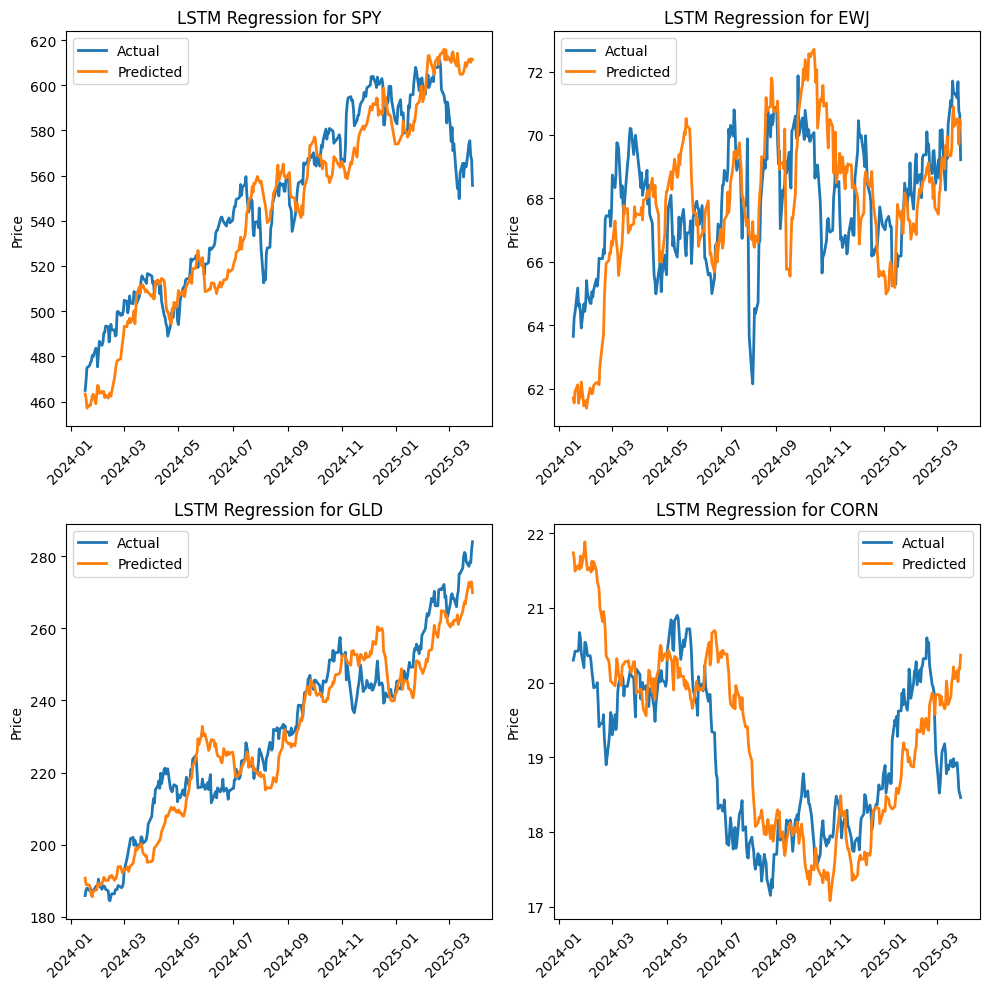

In [12]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [13]:
data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [14]:
labels_test_df = pd.DataFrame(labels_test, index=index_series, columns=data.columns)
labels_test_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2024-01-18,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,0,1,1
2024-01-19,1,1,0,1,0,0,1,1,1,1,...,0,1,1,0,1,1,1,1,1,0
2024-01-22,1,0,1,0,1,0,0,0,0,1,...,0,1,1,1,1,1,1,1,1,1
2024-01-23,1,1,0,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [15]:
display(labels_test_df["SPY"])

Date
2024-01-17    0
2024-01-18    1
2024-01-19    1
2024-01-22    1
2024-01-23    1
             ..
2025-03-24    1
2025-03-25    1
2025-03-26    0
2025-03-27    0
2025-03-28    0
Name: SPY, Length: 310, dtype: int64

In [16]:
Predict_result_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,33.559439,8.822221,76.285262,21.737618,13.727709,109.492027,51.588096,21.883388,34.453656,28.871837,...,22.186314,463.345908,89.234396,66.839206,113.393236,112.330512,60.733090,82.711481,67.398681,6.861546
2024-01-18,32.810875,8.769202,78.097182,21.671688,13.650076,108.323404,51.355366,21.632293,34.323909,28.944529,...,21.855922,461.577352,90.280547,66.659126,112.110516,112.296306,60.663722,81.689018,66.955380,6.784801
2024-01-19,32.654065,8.722761,77.718265,21.492190,13.535937,107.228188,51.135666,21.720252,34.110293,28.833662,...,21.679274,457.048874,90.319600,66.345766,111.038356,111.901409,60.423151,80.842048,66.914255,6.739659
2024-01-22,32.846323,8.693086,77.147811,21.563954,13.567920,106.784546,51.154241,21.830036,33.897311,28.829704,...,21.492722,458.494746,89.593772,66.647379,109.921201,111.268137,60.352722,80.726361,67.150000,6.609750
2024-01-23,33.066000,8.686071,78.837523,21.564981,13.618821,106.635041,50.870377,21.853836,33.853053,28.905912,...,20.914161,458.280480,89.066289,67.329038,109.653757,111.229559,60.391472,80.362422,66.903999,6.524096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,41.051622,10.800345,110.845471,20.155519,14.600676,111.543244,57.534557,25.419496,42.208906,37.089065,...,29.135085,611.476773,87.121074,77.608426,123.066521,146.825934,69.980868,91.164448,76.305779,7.763169
2025-03-25,40.694792,10.839111,110.224683,20.011961,14.715955,112.723074,57.446088,25.385479,42.220765,37.498933,...,29.081366,611.444464,86.698122,78.027469,124.013580,146.841520,70.373310,91.478295,76.180650,7.751062
2025-03-26,40.730839,10.814507,109.572786,20.183993,14.613107,111.921869,57.235318,25.575200,42.075246,37.622392,...,29.283059,610.113569,85.329539,77.826210,122.648848,145.889083,70.715743,90.740526,75.687610,7.730969


In [17]:
y_test_shift = data[-len(y_test) - 1: -1]
y_test_shift_index = data.index[-len(y_test) - 1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,0,1,1,1,1,0,0,0,0,1,...,1,0,0,0,1,0,1,1,0,1
2024-01-18,0,1,1,1,1,0,0,0,0,1,...,1,0,1,0,1,0,1,1,0,1
2024-01-19,0,1,1,1,1,0,0,0,0,1,...,1,0,1,0,1,0,1,1,0,1
2024-01-22,0,1,1,1,1,0,0,0,0,1,...,1,0,1,0,1,0,1,0,0,1
2024-01-23,0,1,1,1,0,0,0,0,0,1,...,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,1,1,1,1,0,...,0,1,0,1,0,1,0,1,1,0
2025-03-25,1,1,1,1,1,1,1,1,1,0,...,0,1,0,1,0,1,0,1,1,0
2025-03-26,1,1,1,1,1,1,1,1,1,0,...,0,1,0,1,0,1,0,1,1,0


In [18]:
actual_flat = labels_test_df.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 50.95%
Accuracy of the model: 0.5095


In [19]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 
Y_pred_mean = Y_pred_denorm.mean(axis=0)
today_prices_predicted = pd.Series(Y_pred_mean.flatten(), index=data.columns)
comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})
tickers_names = data.columns
correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]
    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)
    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list
count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
display(comparison_df)
# save_df = pd.DataFrame()
# save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
# save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
# save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
# save_df['Correct'] = comparison_df['Correct']
# display(save_df)
# save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 20
accuracy: 0.6060606060606061


,Yesterday_actual,Today_actual,Today_pred,Correct
AIEQ,37.658001,36.845001,37.205318,1
ASHR.L,10.460000,10.340000,9.642539,1
BCHN.L,97.080002,92.714996,96.047577,1
CORN,18.510000,18.459999,19.288406,0
DBO,14.130000,13.970000,14.609765,0
EDEN,105.330002,105.169998,121.377434,0
EMXC,56.110001,55.180000,56.819631,0
EWA,23.750000,23.469999,24.332887,0
EWC,41.250000,40.570000,38.474232,1
EWG,37.590000,37.389999,31.588263,1
